![](http://www2.pictures.zimbio.com/bg/Julia+Roberts+Tqw8BcxIW45m.jpg)

### Julia for Management/Analysis of Johns Hopkins Covid Data

Like many analytics geeks, I've been tracking data on the Covid pandemic since early spring.  My source is the [Center for Systems Science and Engineering at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series), with files for download made available at midnight Central time. I've established a pretty [significant R infrastructure in JupyterLab](https://www.datasciencecentral.com/profiles/blogs/johns-hopkins-covid-19-and-r-part-iii-world-data-1) to summarize daily developments. The combination of R data.table and tidyverse programming capabilities has made the computation straightforward. 

There are a few quirks with the data, though, that make it a suitable challenge for less mature data management platforms. The Hopkins data consists of two CSV files, the first detailing Covid cases by date in the U.S., the second U.S. Covid fatalities. Both files are organized similarly. The granularity is sub-state, generally representing counties or other geographic administrations. Each day's data adds a new column depicting cumulative cases/fatalities for the day. The downloaded data must first be pivoted or melted to transform the date columns into rows. split/apply/combine computations within the administrative geography key, uid, then produce daily cases and fatalities. The cases and fatalities dataframes are finally joined to produce a final that's the source of analysis. 

For this blog, I investigate the handling of my Covid data in Julia, using its dataframe package primarily. In subsequent posts, I'll consider Python/Pandas and the new Python datatable. The focus of this exercise is data analysis, consisting of basic wrangling plus display of computations -- both in list and graphical modes. Heavier statistical/ML exercises will come in future blogs.

The code that follows first reads and munges daily cases and fatalities CSV files downloaded from the Hopkins Covid data portal, computing additional attributes such as running sums and moving averages. In the end, I display stats with both listings and graphics.

The results of this inquiry are encouraging. Indeed, I ran into few snarls in the programming journey. I found Julia 1.5.2 much easier to work with than its predecessors, the result of both functionality enhancement/stabilization and documentation availability -- especially tips in StackOverFlow. That's a welcome sign. The performance of Julia is acceptable, actually better than I've experienced so far, though still lagging R and Python on JupyterLab. At least part of this deficit I suspect is that Windows and Jupyter are not ideal Julia staging platforms. In addition, I believe Julia shines more in intensive algorithmic computation than it does in data management/analysis.

The software used below is JupyterLab 2.1.2, Julia 1.5.2, Python 3.7.5, and R 4.0.2. I'll continue investigating Julia for data analysis next time, with a special focus then on divining interoperability with R and Python. 


In [1]:
###############################
###############################

In [2]:
using Pkg
using DataFrames
using RDatasets
using CSV
using DataFramesMeta
using Base
using Dates
using Feather
using Gadfly
using DataTables
using RollingFunctions
using Printf
using Feather
using Glob
#using RCall
using PyCall
using PyPlot


In [3]:
fd = "c:/steve/julia"
cd(fd)

fn = "functions.jl"
include(fn)

masm_1 (generic function with 1 method)

In [4]:
wdir = "/data/covid19/julia"
cd(wdir)

fname = "covidfinal.feather"
covidfinal = Feather.read(fname)

df = DateFormat("YY-mm-dd");
covidfinal[:date] = [Date(string(d),df) for d in covidfinal[:date]]

metaj(covidfinal)

print(last(covidfinal,5))

pr(2)

DataFrame
(1082160, 16)
Any["uid" Int64; "iso2" String; "iso3" String; "code3" Int64; "fips" Union{Missing, Float64}; "admin2" Union{Missing, String}; "provincestate" String; "countryregion" String; "lat" Float64; "long" Float64; "combinedkey" String; "date" Date; "cumcases" Int64; "dailycases" Union{Missing, Int64}; "cumdeaths" Int64; "dailydeaths" Union{Missing, Int64}]


5×16 DataFrame
│ Row │ uid      │ iso2   │ iso3   │ code3 │ fips     │ admin2  │ provincestate  │ countryregion │ lat     │ long    │ combinedkey        │ date       │ cumcases │ dailycases │ cumdeaths │ dailydeaths │
│     │ Int64    │ String │ String │ Int64 │ Float64? │ String? │ String         │ String        │ Float64 │ Float64 │ String             │ Date       │ Int64    │ Int64?     │ Int64     │ Int64?      │
├─────┼──────────┼────────┼────────┼───────┼──────────┼─────────┼────────────────┼───────────────┼─────────┼─────────┼────────────────────┼────────────┼──────────┼────────────┼───────────┼─────────────┤

In [5]:
ustotal = by(covidfinal, [:date], :dailycases => sumna => :dailycases, :dailydeaths => sumna => :dailydeaths);

ustotal["dayofweek"] = Dates.format.(ustotal.date,"e")
ustotal[:cumcases] = cumsum(ustotal.dailycases)
ustotal[:cumdeaths] = cumsum(ustotal.dailydeaths)

ustotal[:macases7] = masm_1(ustotal[:dailycases],window=7);
ustotal[:madeaths7] = masm_1(ustotal[:dailydeaths],window=7);
ustotal[:macases14] = masm_1(ustotal[:dailycases],window=14);
ustotal[:madeaths14] = masm_1(ustotal[:dailydeaths],window=14);

metaj(ustotal)
pr(2)
print(last(ustotal,14))

pr(2)

DataFrame
(324, 10)
Any["date" Date; "dailycases" Int64; "dailydeaths" Int64; "dayofweek" String; "cumcases" Int64; "cumdeaths" Int64; "macases7" Union{Missing, Float64}; "madeaths7" Union{Missing, Float64}; "macases14" Union{Missing, Float64}; "madeaths14" Union{Missing, Float64}]




14×10 DataFrame
│ Row │ date       │ dailycases │ dailydeaths │ dayofweek │ cumcases │ cumdeaths │ macases7 │ madeaths7 │ macases14 │ madeaths14 │
│     │ Date       │ Int64      │ Int64       │ String    │ Int64    │ Int64     │ Float64? │ Float64?  │ Float64?  │ Float64?   │
├─────┼────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┼──────────┼───────────┼───────────┼────────────┤
│ 1   │ 0020-11-27 │ 205514     │ 1402        │ Fri       │ 13088820 │ 264858    │ 166123.0 │ 1477.0    │ 167001.0  │ 1461.0     │
│ 2   │ 0020-11-28 │ 155880     │ 1189        │ Sat       │ 13244700 │ 266047    │ 162949.0 │ 1443.0    │ 166224.0  │ 1456.0     │
│ 3   │ 0020-11-29 │ 138633     │ 826     

In [6]:
last30 = last(ustotal,30);
last15 = last(ustotal,15);

pr(2)

In [7]:
function dtticks(dtarr,skip)
    len = length(dtarr)
    return(dtarr[sort(unique(vcat(collect(1:skip:len),[len]...)))])
end

pr(2)

In [8]:
sb = pyimport("seaborn")

PyObject <module 'seaborn' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\seaborn\\__init__.py'>

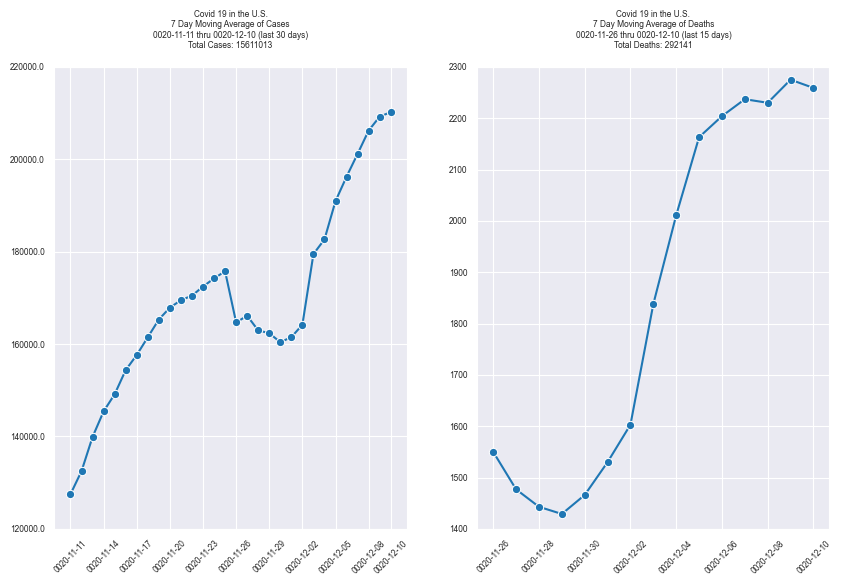

In [10]:
wd = "c:/data/julia"
cd(wd)

fig, (ax1, ax2) = subplots(1,2,figsize=(10,6))

sb.set_style("darkgrid")

tit1 = @sprintf "Covid 19 in the U.S.\n7 Day Moving Average of Cases\n%s thru %s (last 30 days)\nTotal Cases: %s\n"  first(last30).date last(last30).date last(last30).cumcases;
tit2 = @sprintf "Covid 19 in the U.S.\n7 Day Moving Average of Deaths\n%s thru %s (last 15 days)\nTotal Deaths: %s\n"  first(last15).date last(last15).date last(last15).cumdeaths;

l15dmin = minimum(last15.madeaths7)
l15dminr = round(l15dmin/100)*100 
if l15dmin < l15dminr l15dminr -= 100 end 

l15dmax = maximum(last15.madeaths7)
l15dmaxr = round(l15dmax/100)*100 
if l15dmax > l15dmaxr l15dmaxr += 100 end 

l30cmin = minimum(last30.macases7)
l30cminr = round(l30cmin/20000)*20000
if l30cmin < l30cminr l30cminr -= 20000 end 

l30cmax = maximum(last30.macases7)
l30cmaxr = round(l30cmax/20000)*20000 
if l30cmax > l30cmaxr l30cmaxr += 20000 end 



plotcases=sb.lineplot(x=last30.date, y=last30.macases7,marker="o",ax=ax1)
plotcases.set_xticks(dtticks(last30.date,3))
plotcases.set_xticklabels(rotation=45,labels=dtticks(last30.date,3),size=6)
#plotcases.set_yticks(collect(40000:20000:180000))
#plotcases.set_yticklabels(collect(40000:20000:180000),size=6)
plotcases.set_yticks(collect(l30cminr:20000:l30cmaxr))
plotcases.set_yticklabels(collect(l30cminr:20000:l30cmaxr),size=6)
ax1.set_title(label=tit1,size=6) 

plotdeaths=sb.lineplot(x=last15.date, y=last15.madeaths7,marker="o",ax=ax2)
PyPlot.yticks(size=6) 
plotdeaths.set_xticks(dtticks(last15.date,2))
plotdeaths.set_xticklabels(rotation=45,labels=dtticks(last15.date,2),size=6)
ax2.set_title(label=tit2,size=6) 
#plotdeaths.set(ylim=[900,1500])
plotdeaths.set(ylim=[l15dminr,l15dmaxr])

fig.savefig("7ma.png")

pr(2)